In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Python_code import examples as eg
import numpy as np
from numpy import *
import dionysus

The circular coordinates pipeline for examining different smoothness cost-functions:

    Step 1. Getting the point cloud
    Step 2. Computing the Vietoris-Rips filtration and its cohomology
    Step 3. Selecting the Cocycle
    Step 4. First smoothing using Least Squares (Optional)
    Step 5. Second smoothing using a new cost function

## Step 1 - Getting the point cloud

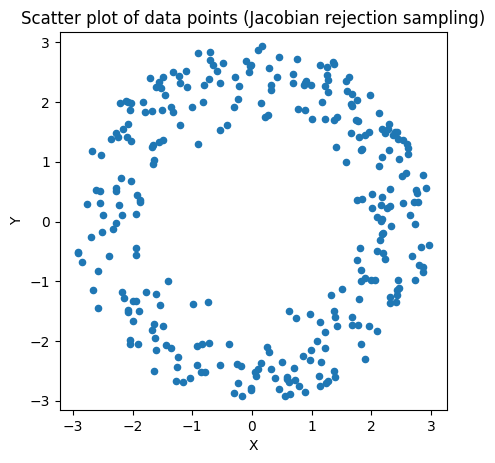

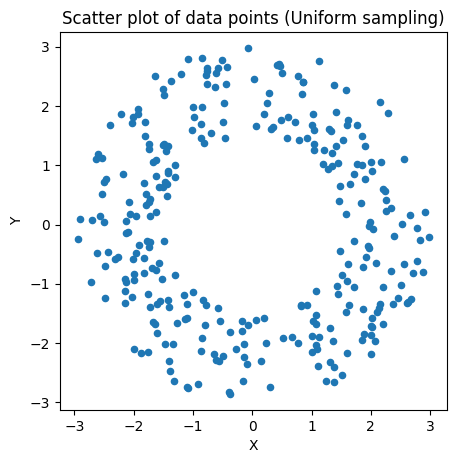

In [3]:
annulusJ = eg.annulus_example(d=1.5,n=300,Jacobian=True)
annulusJ = np.loadtxt('Example1_J.txt')
#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.
#plt.rcParams['lines.markersize'] = 150
#annulusJ=np.transpose(annulusJ)
plt.figure(figsize=(5,5), dpi=100)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', 'datalim')

scatter(annulusJ.T[0,:],annulusJ.T[1,:],s=20)
plt.axis('equal')
plt.title('Scatter plot of data points (Jacobian rejection sampling)')
plt.show()

#np.savetxt('Example1_J.txt',annulusJ)

annulus = eg.annulus_example(d=1.5,n=300,Jacobian=False)
annulus = np.loadtxt('Example1.txt')
#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.
#plt.rcParams['lines.markersize'] = 150
#annulus=np.transpose(annulus)
plt.figure(figsize=(5,5), dpi=100)
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', 'datalim')

scatter(annulus.T[0,:],annulus.T[1,:],s=20)
plt.axis('equal')
plt.title('Scatter plot of data points (Uniform sampling)')
plt.show()

#np.savetxt('Example1.txt',annulusJ)

annulus = annulus

## Step 2 - Computing Vietoris-Rips Complexes and Cohomology

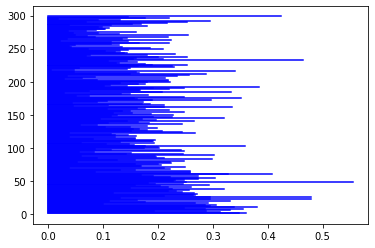

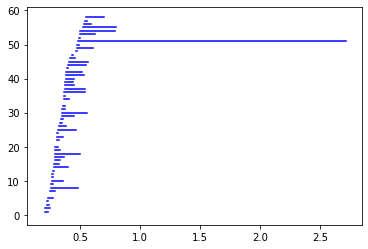

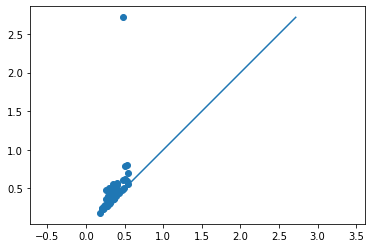

In [4]:
prime = 23 #choose the prime base for the coefficient field that we use to construct the persistence cohomology.

vr = dionysus.fill_rips(annulus, 2, 13.) #Vietoris-Rips complex
cp = dionysus.cohomology_persistence(vr, prime, True) #Create the persistent cohomology based on the chosen parameters.
dgms = dionysus.init_diagrams(cp, vr) #Calculate the persistent diagram using the designated coefficient field and complex.
dionysus.plot.plot_bars(dgms[0], show=True) 
dionysus.plot.plot_bars(dgms[1], show=True) 
dionysus.plot.plot_diagram(dgms[1], show=True) 
#dionysus.plot.plot_diagram(dgms[0], show=True) 
#Plot the barcode and diagrams using matplotlib incarnation within Dionysus2. This mechanism is different in Dionysus.

## Step 3 - Selecting the cocycle and visualization.

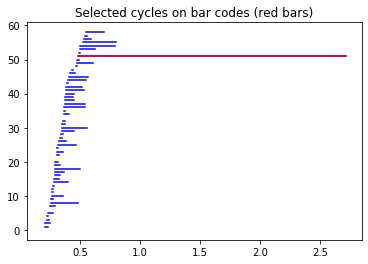

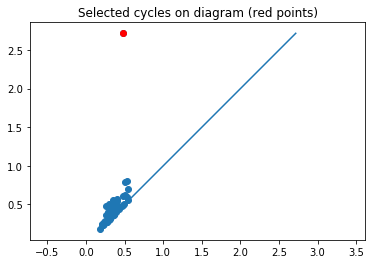

<Figure size 500x500 with 0 Axes>

In [5]:
threshold = 1
bars = [bar for bar in dgms[1] if bar.death-bar.birth > threshold] #choosing cocycle that persist at least threshold=1.
cocycles = [cp.cocycle(bar.data) for bar in bars]
#plt is the matplotlib incarnation.

#Red highlight cocyles that persist more than threshold value on barcode, when more than one cocyles have persisted over threshold values, this plots the first one.
dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > threshold][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > threshold][0],'r')
plt.title('Selected cycles on bar codes (red bars)')
plt.show()

#Red highlight ***ALL*** cocyles that persist more than threshold value on diagram.
dionysus.plot.plot_diagram(dgms[1], show=False)
Lt1 = [[point.birth,point.death] for point in dgms[1] if point.death-point.birth > threshold] 
for Lt3 in Lt1:
    #print(Lt3)
    plt.plot(Lt3[0],Lt3[1],'ro')
plt.title('Selected cycles on diagram (red points)')
plt.figure(figsize=(5,5), dpi=100)
plt.show()


In [6]:
chosen_cocycle= cocycles[0]
chosen_bar= bars[0]

## Step 4 - First smoothing using Least Squares (Optional)

If it is computed the smoothed coefficients can be used as initial condition for the optimization code

In [7]:
vr_8 = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = dionysus.smooth(vr_8, chosen_cocycle, prime)

### Visualization

In [8]:
np.shape(annulus.T)
#annulus.T[1,:]
np.shape(annulusJ.T)
#annulusJ.T[1,:]

(2, 300)

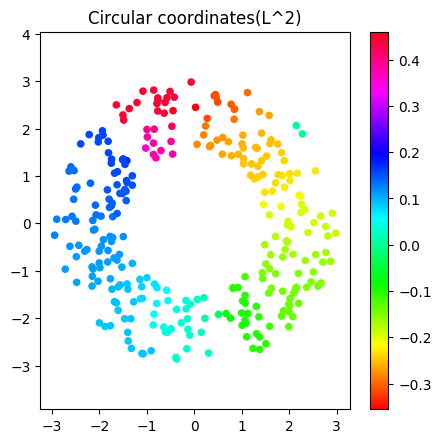

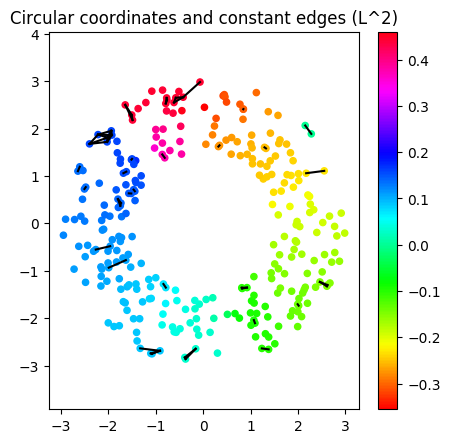

In [9]:
#plt.rcParams['lines.markersize'] = 150
plt.figure(figsize=(5,5), dpi=100)
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=coords, cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('Circular coordinates(L^2)')
plt.show()

toll = 1e-5
p,val = (chosen_bar,coords)
edges_costant = []
thr = p.birth # i want to check all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(val[s[0]]-val[s[1]]) <= toll:
        edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
edges_costant = np.array(edges_costant)

plt.figure(figsize=(5,5), dpi=100)
plt.scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=coords, cmap="hsv")
plt.colorbar()
plot(edges_costant.T[0,:],edges_costant.T[1,:], c='k')
plt.axis('equal')
plt.title('Circular coordinates and constant edges (L^2)')
plt.show()

## Step 5 - Second smoothing using a new cost function

In [10]:
from Python_code import utils
l2_cocycle,f,bdry = utils.optimizer_inputs(vr, bars, chosen_cocycle, coords, prime)

In [11]:
#l2_cocycle.reshape(-1, 1)
l2_cocycle = l2_cocycle.reshape(-1, 1)
l2_cocycle.shape
#f-bdry*l2_cocycle

(300, 1)

In [12]:
##It does not seem to work to have double invokes here...
import scipy as scp
from scipy.optimize import minimize
#cost = lambda z: cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
#grad = lambda z: cost_functions.grad_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
def cost(z):
    from Python_code import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

def grad(z):
    from Python_code import cost_functions
    return cost_functions.grad_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

#res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)
res=scp.optimize.minimize(cost, l2_cocycle, method="Nelder-Mead") 
#res

In [13]:
import tensorflow as tf
#To make this cell run, you need tensorflow 1.2.0
#pip uninstall tensorflow
#pip install tensorflow==1.2.0 --ignore-installed
#import tensorflow_probability as tfp
'''Following seems deprecated in newer version of tfp
#pip install --upgrade tensorflow-probability==0.70
#alternatively, we can use tensorflow to minimize the cost function without gradient information, here we can use multiple black-box functions like Adams
#For more: Check at https://www.tensorflow.org/probability/api_docs/python/tfp/math/minimize
x = tf.Variable(0.)
cost_fun = lambda: cost_functions.cost_Lpnorm_mvj(x, F= f, B= bdry, p= 20)
res_tfp=tfp.math.minimize(
        cost_fun,
        num_steps=1000,
        optimizer=tfp.optimizers.Adam(learning_rate=0.1)
        )
'''
#Following seems working, c.f. 
#https://stackoverflow.com/questions/55552715/tensorflow-2-0-minimize-a-simple-function
def cost(z):
    import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
#type(bdry)
#scipy.sparse.csr.csr_matrix
B_mat = bdry.todense()
import tensorflow as tf
print(f.shape)
print((B_mat*l2_cocycle).shape)
z = tf.Variable(l2_cocycle, trainable=True)

#L1 in tensorflow language
cost_z = tf.reduce_sum( tf.abs(f - tf.matmul(B_mat,z) ) )
#L2 in tensorflow language
cost_z = tf.reduce_sum( tf.pow( tf.abs(f - tf.matmul(B_mat,z) ),2 ) )
#Lp+alpha*Lq norm in tensorflow language
#2020-02-07: I am not sure why @ operator is no longer a valid syntax, but I replace them with tf.matmul.
lp=1
lq=2
alpha=0
cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - tf.matmul(B_mat,z) ),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - tf.matmul(B_mat,z) ),lq ) ), 1/lq)

#Gradient Descedent Optimizer
#opt_gd = tf.train.GradientDescentOptimizer(0.1).minimize(cost_z)
#Adams Optimizer
opt_adams = tf.train.AdamOptimizer(1e-4).minimize(cost_z)
#The latter is much better in terms of result

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):#How many iterations you want to run?
        #print(sess.run([x,loss]))
        sess.run(opt_adams)
    res_tf=sess.run([z,cost_z])
type(res_tf)
#print(res_tf)
res_tf=res_tf[0]
#res_tf

/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:461: Futu

(18719, 1)
(18719, 1)


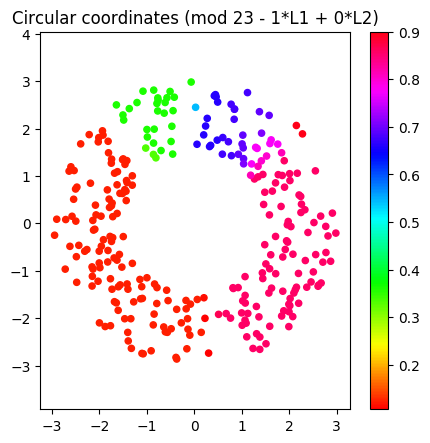

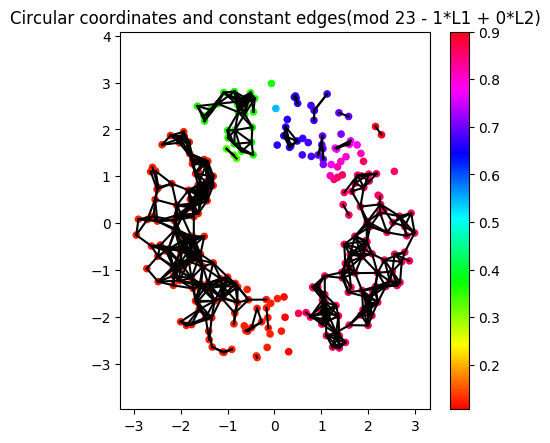

In [14]:
color = np.mod(res_tf.T[0,:],1)
plt.figure(figsize=(5,5), dpi=100)
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=color, cmap="hsv")
#scatter(*annulus.T, c= color, cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('Circular coordinates (mod {} - {}*L{} + {}*L{})'.format(prime,1-alpha,lp,alpha,lq))
plt.show()
toll = 1e-5
edges_constant = []
thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(color[s[0]]-color[s[1]]) <= toll:
        edges_constant.append([annulus[s[0],:],annulus[s[1],:]])
edges_constant = np.array(edges_constant)        
#scatter(*annulus.T, c=color, cmap="hsv", alpha=.5)

plt.figure(figsize=(5,5), dpi=100)
#plot(*edges_constant.T, c='k')
plot(edges_constant.T[0,:],edges_constant.T[1,:], c='k')
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=color, cmap="hsv")
edges_constant.shape
plt.colorbar()
plt.axis('equal')
plt.title('Circular coordinates and constant edges(mod {} - {}*L{} + {}*L{})'.format(prime,1-alpha,lp,alpha,lq))
plt.show()